In [11]:
from qiskit import *
from qiskit.providers.fake_provider import FakeManila, FakeKolkata
from qiskit_ibm_provider import IBMProvider

import mthree
from mthree.utils import *
from mthree.generators.random import RandomGenerator, RandomComplimentGenerator
from mthree.generators import HadamardGenerator
from mthree._helpers import system_info

from mthree.twirling.tw_calibrations import Tw_Calibration
from mthree.twirling.tw_circuits import Tw_Circuits
from mthree.twirling.tw_utils import flatten_with_sum, minimal_qubits_to_calib, tw_expval

from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

import matplotlib.pyplot as plt 

In [12]:
provider = IBMProvider()
backend = FakeKolkata()
#backend = provider.get_backend('ibm_seattle')
#backend = provider.get_backend('ibm_nazca')
#len(backend.properties().qubits)

In [13]:
def all_z_op_string(qc, num_backend_qubits):
    operator_string = list(num_backend_qubits*'I')
    for key,value in final_measurement_mapping(qc).items():
        little_endian_index = num_backend_qubits-1-value
        operator_string[little_endian_index] = 'Z'
    operator_string = "".join(operator_string)
    return operator_string

def all_z_op(qc, num_backend_qubits):
    operator_string = list(num_backend_qubits*'I')
    for key,value in final_measurement_mapping(qc).items():
        little_endian_index = num_backend_qubits-1-value
        operator_string[little_endian_index] = 'Z'
    operator_string = "".join(operator_string)
    op = SparsePauliOp.from_list([(operator_string, 1)])
    return op

def all_z_op_list(qc_list, num_backend_qubits):
    all_z_op_list = []
    for qc in qc_list:
        all_z_op_list.append(all_z_op(qc,num_backend_qubits))
    return all_z_op_list


def extract_element(loc, arr):
    # extract all elements at location loc from an array of arrays 
    return np.array([sub_arr[loc] if len(sub_arr) >= loc+1 else None for sub_arr in arr])

def chop_dict_length(dict_list, length):
    """
    Chop up a list of dictionaries into a list of list of dictionaries each of the given length

    Parameters:
        length (int): Integer specifying the length of sublists.
        dict_list (list): List of dictionaries.

    Returns:
        list: List of list of dictionaries.
    """
    result = []
    remaining_dicts = dict_list[:]
    while len(remaining_dicts)>=length:
        sublist = remaining_dicts[:length]
        result.append(sublist)
        remaining_dicts = remaining_dicts[length:]
    return result

In [14]:
def GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def untranspiled_GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    return qc

def untranspiled_m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    return qc

def untranspiled_donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    return qc

In [15]:
def convert_to_probabilities(counts):
    total_counts = sum(counts.values())
    probabilities = {bitstring: count / total_counts for bitstring, count in counts.items()}
    return probabilities

def total_variation_distance(counts1, counts2):
    probabilities1 = convert_to_probabilities(counts1)
    probabilities2 = convert_to_probabilities(counts2)
    all_keys = set(probabilities1.keys()).union(set(probabilities2.keys()))
    tv_distance = 0.0
    for bitstring in all_keys:
        prob1 = probabilities1.get(bitstring, 0.0)
        prob2 = probabilities2.get(bitstring, 0.0)
        tv_distance += abs(prob1 - prob2)
    return tv_distance / 2.0

def kl_divergence(counts1, counts2):
    probabilities1 = convert_to_probabilities(counts1)
    probabilities2 = convert_to_probabilities(counts2)
    kl_divergence = 0.0
    for bitstring in probabilities1.keys():
        prob1 = probabilities1.get(bitstring, 0.0)
        prob2 = probabilities2.get(bitstring, 0.0)
        if prob2==0:
            return np.inf
        else:
            kl_divergence += prob1*np.log(prob1/prob2)
    return kl_divergence

In [16]:
def ManyParallel_uint2bits(in_intAr,Nbits):
    ''' convert (numpyarray of uint => array of Nbits bits) for many bits in parallel'''
    inSize_T= in_intAr.shape
    in_intAr_flat=in_intAr.flatten()
    out_NbitAr= np.zeros((len(in_intAr_flat),Nbits))
    for iBits in range(Nbits):
        out_NbitAr[:,iBits]= (in_intAr_flat>>iBits)&1
    out_NbitAr= out_NbitAr.reshape(inSize_T+(Nbits,))
    out_NbitAr = np.flip(out_NbitAr)
    return out_NbitAr.astype('uint8')

class CompleteGenerator:
    """Complete bit-array generator with every bit array"""

    def __init__(self, num_qubits, seed=None):
        """Generator of random arrays corresponding to random x-gates on
        qubits for TexMex mitigation

        Parameters:
            num_qubits (int): Number of qubits
            seed (int): seed for RNG, default=None

        Attributes:
            num_qubits (int): Number of qubits / length of arrays
            length (int): Total number of generated arrays, default=16
            seed (int): Seed used for RNG
        """
        self.name = "random"
        self.seed = seed
        if self.seed is None:
            self.seed = np.random.randint(0, np.iinfo(np.int32).max)
        self._RNG = np.random.default_rng(seed=self.seed)
        self.num_qubits = num_qubits
        self.length = 2**num_qubits
        self._iter_index = 0

    def __iter__(self):
        self._RNG = np.random.default_rng(seed=self.seed)
        self._iter_index = 0
        return self

    def __next__(self):
        if self._iter_index < self.length:
            self._iter_index += 1
            return ManyParallel_uint2bits(np.asarray(self._iter_index),self.num_qubits)
        else:
            raise StopIteration

In [17]:
gen = CompleteGenerator(num_qubits=10)
print(len(list(gen)))
#gen = RandomGenerator(num_qubits=3, num_arrays=5)

1024


In [42]:
N=5
qubits_for_calib = range(N)

all_tw_qc = Tw_Calibration(backend, qubits = qubits_for_calib, generator=CompleteGenerator)
all_tw_qc.tw_calibrate_from_backend(shots=2**17)
all_data = all_tw_qc.to_tw_calibration()

# all_tw_qc = Tw_Circuits(backend, circuits=m3circuit(N),  generator=CompleteGenerator)
# all_tw_qc.tw_data_from_backend(shots=2**15)
# all_data = all_tw_qc.to_tw_circuits_data()
# all_data = all_data[0]
print(all_data)

def random_tvd(gen_length, trials, total_calib_shots):
    tvds = []
    for _ in range(trials):
        tw_qc = Tw_Calibration(backend, qubits = qubits_for_calib, generator=RandomGenerator, num_random_circuits=gen_length)
        tw_qc.tw_calibrate_from_backend(shots=int(total_calib_shots/gen_length))
        # tw_qc = Tw_Calibration(backend, qubits = qubits_for_calib, generator=HadamardGenerator)
        # tw_qc.tw_calibrate_from_backend(shots=int(total_calib_shots/8))
        data = tw_qc.to_tw_calibration()

        # tw_qc = Tw_Circuits(backend, circuits=m3circuit(N),  generator=RandomGenerator, num_random_circuits=gen_length)
        # tw_qc.tw_data_from_backend(shots=int(total_calib_shots/gen_length))
        # data = tw_qc.to_tw_circuits_data()
        # data = data[0]
        
        tvds.append(total_variation_distance(all_data, data))
    return np.average(tvds), np.std(tvds)

def random_compliment_tvd(gen_length, trials, total_calib_shots):
    tvds = []
    for _ in range(trials):
        tw_qc = Tw_Calibration(backend, qubits = qubits_for_calib, generator=RandomComplimentGenerator, num_random_circuits=gen_length)
        tw_qc.tw_calibrate_from_backend(shots=int(total_calib_shots/gen_length))
        data = tw_qc.to_tw_calibration()

        # tw_qc = Tw_Circuits(backend, circuits=m3circuit(N),  generator=RandomComplimentGenerator, num_random_circuits=gen_length)
        # tw_qc.tw_data_from_backend(shots=int(total_calib_shots/gen_length))
        # data = tw_qc.to_tw_circuits_data()
        # data = data[0]
        
        tvds.append(total_variation_distance(all_data, data))
    return np.average(tvds), np.std(tvds)

{'11001': 11, '01010': 403, '10011': 16, '00101': 313, '00011': 487, '00100': 29358, '11000': 721, '10001': 830, '01100': 247, '10010': 973, '00001': 38781, '01001': 362, '10000': 83170, '10100': 602, '00000': 3953967, '00010': 48234, '00110': 373, '01000': 35407, '11010': 13, '01011': 5, '01101': 7, '11100': 8, '10101': 4, '10110': 3, '01110': 4, '11011': 1, '00111': 4}


In [46]:
trial_num = 10
total_calib_shots = 2**9
lengths = [2,4,8,16,32]
num = len(lengths)
compliment_tvds = np.zeros(num)
random_tvds = np.zeros(num) 
compliment_tvds_std = np.zeros(num)
random_tvds_std= np.zeros(num)
for i in range(num):
    compliment_tvds[i], compliment_tvds_std[i]=random_compliment_tvd(gen_length=lengths[i],trials=trial_num, total_calib_shots=total_calib_shots)
    random_tvds[i], random_tvds_std[i]=random_tvd(gen_length=lengths[i],trials=trial_num, total_calib_shots=total_calib_shots)

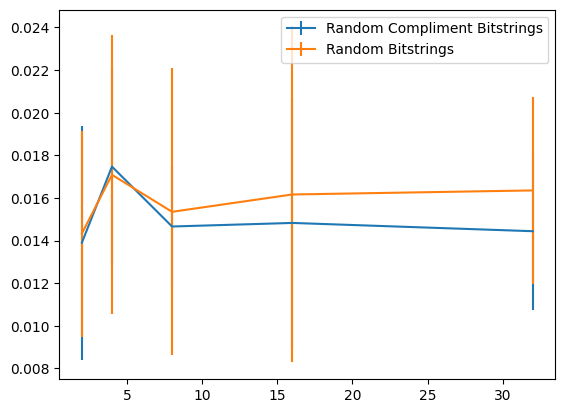

In [47]:
plt.errorbar(lengths, compliment_tvds, yerr=compliment_tvds_std, label='Random Compliment Bitstrings')
plt.errorbar(lengths, random_tvds, yerr=random_tvds_std, label='Random Bitstrings')
plt.legend()
#plt.savefig("bitstrings.svg",bbox_inches ="tight", transparent = True, orientation ='landscape')
plt.show()

In [30]:
# circ_shots = 512
# calib_shots = 512

# tw_qc = Tw_Circuits(backend, circuits=circuit_list, generator=HadamardGenerator)
# tw_qc.tw_data_from_backend(shots=circ_shots)

# tw_cal = Tw_Calibration(backend, qubits=qubits_to_calibrate, generator=HadamardGenerator)
# tw_cal.tw_calibrate_from_backend(shots=calib_shots)

# tw_results = []
# for qc,op in zip(unrepeated_circuit_list, unrepeated_op_list):
#     tw_results.append(tw_expval(quantum_circ=qc, operator=op, tw_circuits=tw_qc, tw_calibration=tw_cal))

# #donothing_nazca_10_20_30_40_July_10_1024_circ_1024_calib = [[[0.7947998046875, 0.9096433935245014, 0.04023773274551807], [0.79443359375, 0.9092242674024659, 0.04023773274551807], [0.7958984375, 0.910900771890608, 0.04023773274551807], [0.798583984375, 0.9139743634522022, 0.04023773274551807], [0.798095703125, 0.9134155286228214, 0.04023773274551807], [0.8006591796875, 0.9163494114770703, 0.04023773274551807], [0.7891845703125, 0.9032167929866229, 0.04023773274551807], [0.796875, 0.9120184415493696, 0.04023773274551807], [0.802001953125, 0.9178862072578673, 0.04023773274551807], [0.8026123046875, 0.9185847507945932, 0.04023773274551807]], [[0.621826171875, 0.9338221814848763, 0.04266696643318427], [0.609619140625, 0.9154903758020165, 0.04266696643318427], [0.6163330078125, 0.9255728689275894, 0.04266696643318427], [0.61138916015625, 0.9181484876260312, 0.04266696643318427], [0.61883544921875, 0.9293308890925757, 0.04266696643318427], [0.62689208984375, 0.9414298808432631, 0.04266696643318427], [0.63128662109375, 0.9480293308890926, 0.04266696643318427], [0.62823486328125, 0.9434463794683776, 0.04266696643318427], [0.6239013671875, 0.9369385884509625, 0.04266696643318427], [0.62762451171875, 0.9425297891842347, 0.04266696643318427]], [[0.48687744140625, 0.9629987324198708, 0.056512323956514586], [0.49798583984375, 0.9849701213255266, 0.056512323956514586], [0.486083984375, 0.9614293474980383, 0.056512323956514586], [0.48602294921875, 0.9613086255809742, 0.056512323956514586], [0.48681640625, 0.9628780105028067, 0.056512323956514586], [0.4830322265625, 0.9553932516448361, 0.056512323956514586], [0.4818115234375, 0.9529788133035553, 0.056512323956514586], [0.479736328125, 0.9488742681233778, 0.056512323956514586], [0.48583984375, 0.9609464598297821, 0.056512323956514586], [0.4881591796875, 0.9655338926782158, 0.056512323956514586]], [[0.363494873046875, 0.9766316825188587, 0.0641331797864957], [0.365936279296875, 0.9831912102328633, 0.0641331797864957], [0.356964111328125, 0.9590849458838964, 0.0641331797864957], [0.3564453125, 0.9576910462446704, 0.0641331797864957], [0.349884033203125, 0.940062315513283, 0.0641331797864957], [0.362701416015625, 0.9744998360118071, 0.0641331797864957], [0.34619140625, 0.9301410298458511, 0.0641331797864957], [0.33612060546875, 0.9030829780255821, 0.0641331797864957], [0.34307861328125, 0.9217776320104952, 0.0641331797864957], [0.341766357421875, 0.9182518858642178, 0.0641331797864957]]]
# #donothing_seattle_10_20_30 = [[[0.3515625, 1.1000763941940412, 0.3900842247653776], [0.318359375, 0.9961802902979373, 0.3900842247653776], [0.3046875, 0.9533995416348358, 0.3900842247653776], [0.330078125, 1.0328495034377387, 0.3900842247653776], [0.255859375, 0.80061115355233, 0.3900842247653776], [0.314453125, 0.983957219251337, 0.3900842247653776], [0.333984375, 1.0450725744843392, 0.3900842247653776], [0.30078125, 0.9411764705882353, 0.3900842247653776], [0.2890625, 0.904507257448434, 0.3900842247653776], [0.30859375, 0.9656226126814362, 0.3900842247653776]], [[0.0625, 0.8139904610492846, 1.6502924060746658], [0.0478515625, 0.6232114467408585, 1.6502924060746658], [0.03125, 0.4069952305246423, 1.6502924060746658], [0.0302734375, 0.3942766295707472, 1.6502924060746658], [0.0947265625, 1.2337042925278219, 1.6502924060746658], [0.03515625, 0.4578696343402226, 1.6502924060746658], [0.0732421875, 0.9538950715421304, 1.6502924060746658], [0.0849609375, 1.1065182829888711, 1.6502924060746658], [0.0634765625, 0.8267090620031796, 1.6502924060746658], [0.0732421875, 0.9538950715421304, 1.6502924060746658]], [[0.0517578125, 1.1943661971830986, 4.3819459615657195], [0.009765625, 0.22535211267605634, 4.3819459615657195], [0.0634765625, 1.4647887323943662, 4.3819459615657195], [0.0, 0.0, 4.3819459615657195], [0.0556640625, 1.2845070422535212, 4.3819459615657195], [0.0693359375, 1.6, 4.3819459615657195], [0.0361328125, 0.8338028169014085, 4.3819459615657195], [0.01953125, 0.4507042253521127, 4.3819459615657195], [0.0166015625, 0.38309859154929576, 4.3819459615657195], [0.0400390625, 0.923943661971831, 4.3819459615657195]]]

5

In [ ]:
# #print(tw_results)

# tw_unmitigated_list = []
# tw_mitigated_list = []
# for index in range(len(N_arr)):
#     tw_unmitigated_vals = extract_element(loc=0, arr=tw_results[index])
#     tw_unmitigated_list.append(np.average(tw_unmitigated_vals))
#     tw_mitigated_vals = extract_element(loc=1, arr=tw_results[index])
#     tw_mitigated_list.append(np.average(tw_mitigated_vals))

# plt.semilogy(N_arr, tw_unmitigated_list)
# plt.semilogy(N_arr, tw_mitigated_list)
# plt.show()
    

# #tw_mitigated_vals = extract_element(loc=1, arr=tw_results[index])
# #print(np.average(tw_mitigated_vals))
# #print(2*np.std(tw_mitigated_vals))

# #tw_uncertainity_estimates = extract_element(loc=2, arr=tw_results[index])
# #print(np.average(tw_uncertainity_estimates))

In [49]:
# mit = mthree.M3Mitigation(backend)
# mit.cals_from_system(qubits=qubits_to_calibrate, shots=8192)

# m3_results_bunched = []
# for circuit in circuit_list:
#     raw_counts = backend.run(circuit, shots=8192).result().get_counts()
#     quasi = mit.apply_correction(raw_counts, final_measurement_mapping(circuit), return_mitigation_overhead=True)
#     result = quasi.expval_and_stddev()
#     m3_results_bunched.append(result)

In [108]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits=range(5), shots=8192)

In [50]:
m3_results = chop_dict_length(dict_list=m3_results_bunched, length=repeats)

index=0
print(m3_results[index])
m3_vals = extract_element(loc=0, arr=m3_results[index])
m3_uncertainity_vals = extract_element(loc=1, arr=m3_results[index])

m3_mitigated_vals = np.average(m3_vals)
print(m3_mitigated_vals)

m3_uncertainity = 2*np.std(m3_vals)
print(m3_uncertainity)

m3_uncertainity_estimate = 2*np.average(m3_uncertainity_vals)
print(m3_uncertainity_estimate)

[(0.3819700980930373, 0.014094707042488315), (0.36496245793309223, 0.014082884077884448), (0.3647622977431757, 0.014094559662962984), (0.37991425531553263, 0.014094932350070592), (0.39810796112508434, 0.014105238860693578), (0.38069069613182804, 0.013710604482889282), (0.39144255803670325, 0.013709144414854492), (0.39142566987736843, 0.014090329723324278), (0.3615244574540298, 0.01408877940507118), (0.3882129926800689, 0.013723104491280436)]
0.3803013444389921
0.024165662419014914
0.02795885690230392


In [51]:
# Make a noise model
backend = FakeKolkata()
noise_model = NoiseModel.from_backend(backend)
num_backend_qubits = system_info(backend)["num_qubits"]

circs = circuit_list
ops = all_z_op_list(circuit_list, num_backend_qubits)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": backend.configuration().basis_gates,
    "coupling_map": backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 8192
options.optimization_level = 0
options.resilience_level = 0

# Set options to include the noise model with error mitigation
options_with_em = Options()
options_with_em.simulator = {
    "noise_model": noise_model,
    "basis_gates": backend.configuration().basis_gates,
    "coupling_map": backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_with_em.execution.shots = 8192
options_with_em.optimization_level = 0 # no optimization
options_with_em.resilience_level = 1 # M3 for Sampler and T-REx for Estimator

with Session(backend="ibmq_qasm_simulator"):
    # # include the noise model without T-REx
    # estimator = Estimator(options=options)
    # #job = estimator.run(circuits=[qc], observables=[op])
    # job = estimator.run(circuits=circuit_list, observables=all_z_op_list)
    # result = job.result()
    # print(f"Expectation value without T-REx: {np.average(result.values)}")
    # print(f"Std without T-REx: {2*np.std(result.values)}")
    # print(f"Metadata without T-REx: {result.metadata}")

    # include the noise model with T-REx
    estimator = Estimator(options=options_with_em)
    #job = estimator.run(circuits=[qc], observables=[op])
    job = estimator.run(circuits=circs, observables=ops)
    trex_result = job.result()
    #print(f"Expectation value with T-REx: {np.average(trex_result.values)}")
    #print(f"Std with T-REx: {2*np.std(trex_result.values)}")
    #print(f"Metadata with T-REx: {trex_result.metadata}")

In [52]:
expvals_trex_variance = [metadata["variance"] / metadata["shots"] for metadata in trex_result.metadata]

trex_results = chop_dict_length(dict_list=trex_result.values, length=repeats)
trex_std_results = chop_dict_length(dict_list=np.sqrt(expvals_trex_variance), length=repeats)

index=0
print(trex_results[index])
print(trex_std_results[index])

trex_mitigated_vals = np.average(trex_results[index])
print(trex_mitigated_vals)

trex_uncertainity = 2*np.std(trex_results[index])
print(trex_uncertainity)

trex_uncertainity_estimate = 2*np.average(trex_std_results[index])
print(trex_uncertainity_estimate)

[0.37630129 0.37630129 0.38732394 0.38977342 0.39804042 0.42559706
 0.37875077 0.3781384  0.40293938 0.38028169]
[0.0132179  0.0132179  0.01317898 0.01317016 0.01313994 0.01303409
 0.01320936 0.0132115  0.0131217  0.01320399]
0.3893447642375995
0.029927537467497167
0.026341102466944842


In [13]:
# backend = provider.get_backend('ibm_nazca')
# num_backend_qubits = system_info(backend)["num_qubits"]
# circs = circuit_list
# ops = all_z_op_list(circuit_list, num_backend_qubits)

# # Set options to include the noise model
# options = Options()

# # Set number of shots, optimization_level and resilience_level
# options.execution.shots = int(1024*64)
# options.optimization_level = 0
# options.resilience_level = 0

# # Set options to include the noise model with error mitigation
# options_with_em = Options()

# # Set number of shots, optimization_level and resilience_level
# options_with_em.execution.shots = int(1024*64)
# options_with_em.optimization_level = 0 # no optimization
# options_with_em.resilience_level = 1 # M3 for Sampler and T-REx for Estimator

40

In [16]:
# with Session(backend='ibm_nazca'):
#     # # include the noise model without T-REx
#     # estimator = Estimator(options=options)
#     # #job = estimator.run(circuits=[qc], observables=[op])
#     # job = estimator.run(circuits=circuit_list, observables=all_z_op_list)
#     # result = job.result()
#     # print(f"Operator: {op}")
#     # print(f"Avg Expectation value without T-REx: {np.average(result.values)}")
#     # print(f"Std without T-REx: {2*np.std(result.values)}")
#     # print(f"Metadata without T-REx: {result.metadata}")

#     # include the noise model with T-REx
#     estimator = Estimator(options=options_with_em)
#     #job = estimator.run(circuits=[qc], observables=[op])
#     job = estimator.run(circuits=circs, observables=ops)
#     trex_result = job.result()

Expectation values with T-REx: [1.00565844 1.01043504 1.01462375 1.0175632  1.00698119 1.00393151
 1.02083333 1.0218254  1.01521164 1.00157995 1.0088434  1.00372615
 0.97466216 1.00765103 1.01420906 1.00511725 0.99219992 0.97858704
 0.9858903  1.0757651  1.28452908 1.28018331 1.26619785 1.26311631
 1.31052465 1.2818426  1.26722503 1.26619785 1.26382743 1.28073641
 1.0379119  0.98428043 0.99445192 0.97999328 0.97621049 0.99873907
 1.03732347 0.97007397 0.96477808 0.9539341 ]
Avg Expectation value with T-REx: 1.0706843027905777
Std with T-REx: 0.24164742343563278
Metadata with T-REx: [{'variance': 0.43826144712571813, 'shots': 65536, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 0.4286313710059546, 'shots': 65536, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 0.42014898189881045, 'shots': 65536, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_

In [54]:
# expvals_trex_variance = [metadata["variance"] / metadata["shots"] for metadata in trex_result.metadata]

# trex_results = chop_dict_length(dict_list=trex_result.values, length=repeats)
# trex_std_results = chop_dict_length(dict_list=np.sqrt(expvals_trex_variance), length=repeats)

# index=0
# print(trex_results[index])
# print(trex_std_results[index])

# trex_mitigated_vals = np.average(trex_results[index])
# print(trex_mitigated_vals)

# trex_uncertainity = 2*np.std(trex_results[index])
# print(trex_uncertainity)

# trex_uncertainity_estimate = 2*np.average(trex_std_results[index])
# print(trex_uncertainity_estimate)

[1.28452908 1.28018331 1.26619785 1.26311631 1.31052465 1.2818426
 1.26722503 1.26619785 1.26382743 1.28073641]
[0.0087813  0.00879098 0.00882184 0.00882857 0.0087225  0.00878729
 0.00881958 0.00882184 0.00882702 0.00878975]
1.2764380530973451
0.02771405982341234
0.017598136663178738


In [9]:
# # Run for a list of circuits and obtain the estimates for circuits on real hardware
# # implement code that does trex inside the runtime envrionment
# # see if it possible to reproduce the plot shared by Paul